# Capstone: West Nile Virus Challenge
 
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, we are asked to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns',1000)

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from imblearn.over_sampling import SMOTENC, ADASYN
from imblearn.pipeline import Pipeline, make_pipeline
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.svm import SVC
from datetime import datetime
from sklearn.impute import SimpleImputer, KNNImputer
import tensorflow as tf
# from keras.wrappers.scikit_learn import KerasClassifier

from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display
from IPython.display import Image

ModuleNotFoundError: No module named 'keras'

## Data Loading and Cleaning

### Training and Test data:
The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we are requested 
to predict the test results for 2008, 2010, 2012, and 2014.

In [54]:
train = pd.read_csv('./datasets/train.csv')

# Make Date into datetime object, and index:
train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')
train.set_index('Date', inplace=True, drop=True)
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


We make a note here of the baseline to be bettered through modelling:

In [55]:
print('Baseline = {}'.format(train.WnvPresent.value_counts(normalize=True).max()))
train.WnvPresent.value_counts()

# we can see clearly the problem: only 5% of those traps inspected carried Wnv, can we improve on this?
# we also see a class imbalance here that will need to be resolved before modelling

Baseline = 0.9475537787930707


0    9955
1     551
Name: WnvPresent, dtype: int64

In [56]:
test = pd.read_csv('./datasets/test.csv')
# Make Date into datetime object, and index
test['Date'] = pd.to_datetime(test.Date, format='%Y-%m-%d')
test.set_index('Date', inplace=True, drop=True)
test.head(1)

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### Weather Data:
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
We are provided with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of
the tests. 
    Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
    Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [129]:
weather = pd.read_csv('./datasets/weather.csv')
weather.head(30)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [57]:
weather = pd.read_csv('./datasets/weather.csv')
# Make Date into datetime object, and index
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
weather.set_index('Date', inplace=True, drop=True)

# Data Cleaning:
weather['Tavg'] = pd.to_numeric(weather.apply(lambda x: (x['Tmin']+x['Tmax'])/2, axis=1))
weather['PrecipTotal'] = pd.to_numeric(weather.apply(lambda x: 0 if x['PrecipTotal']=='  T' or x['PrecipTotal']=='M' else x['PrecipTotal'], axis=1))


# Add Long / Lat:
weather.insert(1,'Latitude', weather.apply(lambda x: 41.995 if x['Station']==1 else 41.786, axis=1))
weather.insert(2,'Longitude', weather.apply(lambda x: -87.933 if x['Station']==1 else -87.752, axis=1))

weather.head()

,Station,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,41.995,-87.933,59,42,50.5,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4
2007-05-02,2,41.786,-87.752,60,43,51.5,M,42,47,13,0,-,-,BR HZ,M,M,M,0.0,29.44,30.08,13.3,2,13.4
2007-05-03,1,41.995,-87.933,66,46,56.0,2,40,48,9,0,0446,1851,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9


In [59]:
# Reformatting weather data into flattened version for merging with train data:
weather_station_1 = weather[weather['Station']==1]
weather_station_2 = weather[weather['Station']==2]

weather_df = weather_station_1.merge(weather_station_2,
                                     how='inner',
                                     on='Date',
                                     suffixes=('_station_1','_station_2'))

weather_df.head(1)

,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6


#### PCA
Many weather features to comprehend, some of which are highly correlated as evidenced by the heatmap.
We will use the cumulated explained_variance_ratio to test this

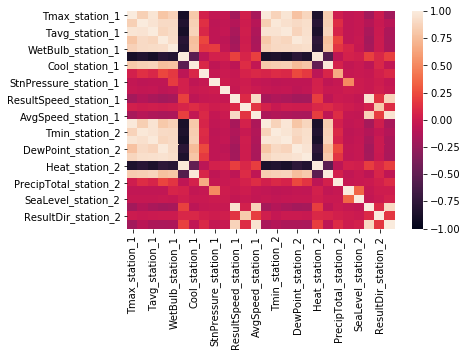

In [131]:
# Prepare a weather_pca dataframe with string dtypes converted to numeric, and standardise:
weather_pca = weather_df.drop(columns=['Station_station_1','Station_station_2',
                                       'Latitude_station_1','Longitude_station_1',
                                       'Latitude_station_2','Longitude_station_2',
                                       'Depth_station_1','Water1_station_1',
                                       'Depth_station_2','Water1_station_2',
                                       'Sunrise_station_1','Sunset_station_1',
                                       'Sunrise_station_2','Sunset_station_2',
                                       'Depart_station_1','Depart_station_2',
                                       'SnowFall_station_1','SnowFall_station_2',
                                       'CodeSum_station_1','CodeSum_station_2']).replace({'M':0,'  T':0, '-':0}).apply(pd.to_numeric)
scaler = StandardScaler()
weather_pca = pd.DataFrame(scaler.fit_transform(weather_pca), columns=weather_pca.columns)

# Check heatmap for any correlations that would be helped with PCA:
sns.heatmap(weather_pca.corr(), vmin=-1, vmax=1);

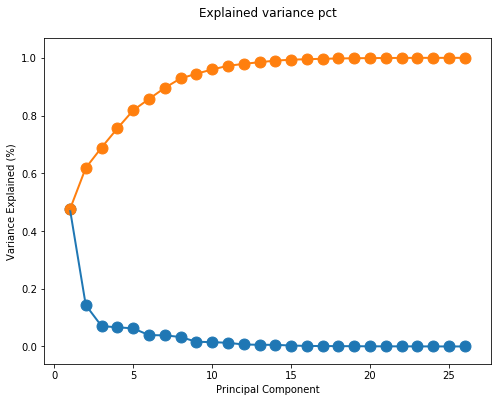

In [132]:
# Fit PCA model and assess:
pca = PCA()
pca.fit(weather_pca)

# Plot the explained_variance_ratio_
plt.figure(figsize=(8,6))
x_values = list(range(1, pca.n_components_+1))
plt.plot(x_values, pca.explained_variance_ratio_, lw=2)
plt.scatter(x_values, pca.explained_variance_ratio_, s=120)
plt.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2)
plt.scatter(x_values, np.cumsum(pca.explained_variance_ratio_), s=120)
plt.title('Explained variance pct\n')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.show()

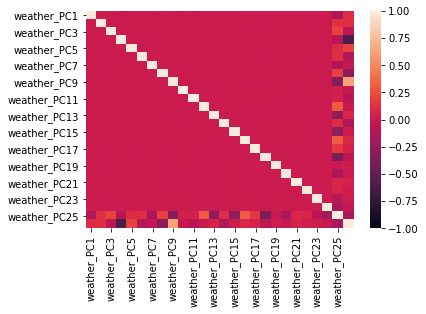

In [133]:
weather_dict = {'weather_PC'+str(i+1): pca.components_[i] for i in range(len(pca.components_))}
weather_pca_df = pd.DataFrame(weather_dict, index=weather_pca.columns)

weather_pcs = pd.DataFrame(pca.transform(weather_pca),
                           columns=['weather_PC'+str(i+1) for i in range(len(weather_pca.columns))],
                           index=weather_df.index)
sns.heatmap(weather_pcs.corr(), vmin=-1, vmax=1);

### Spray Data

The City of Chicago also does spraying to kill mosquitos. We are given the GIS data for their spray efforts
in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

In [63]:
spray = pd.read_csv('./datasets/spray.csv')
spray['Time'] = spray['Time'].fillna(value=spray.mode().Time[0])
spray['DateTime'] = spray.apply(lambda x: str(x['Date'])+' '+str(x['Time']), axis=1)
spray['DateTime'] = spray.apply(lambda x: datetime.strptime(str(x['DateTime']), '%Y-%m-%d %I:%M:%S %p'), axis=1)
spray['Date'] = spray.apply(lambda x: datetime.strptime(str(x['Date']), '%Y-%m-%d'), axis=1)
spray['Latitude2'] = np.round(spray.Latitude,2)
spray['Longitude2'] = np.round(spray.Longitude,2)
spray.set_index('DateTime', inplace=True, drop=True)
spray.head(1)

,Date,Time,Latitude,Longitude,Latitude2,Longitude2
DateTime,,,,,,
2011-08-29 18:56:58,2011-08-29,6:56:58 PM,42.391623,-88.089163,42.39,-88.09


## EDA: visualise and analyse data

### Prepare train dataframe

In [135]:
# Merging weather data onto train data:
train_df = train.merge(weather_df, how='left', on='Date', suffixes=('',''))
# Merging weather_pcs data onto train data:
train_df = train_df.merge(weather_pcs, how='left', on='Date', suffixes=('',''))
train_df.head(1)
# Merging spray data onto train data:
train_df['Latitude2'] = np.round(train_df.Latitude,2)
train_df['Longitude2'] = np.round(train_df.Longitude,2)
spray_df = spray.drop_duplicates(subset=['Date','Latitude2','Longitude2'])
train_df = train_df.merge(spray_df, how='left', on=['Date','Latitude2','Longitude2'], suffixes=('','_spray'))
train_df['isSpray'] = [0 if x==0 else 1 for x in train_df.Time.fillna(value=0)]
train_df.set_index('Date', inplace=True, drop=True)
train_df.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2,weather_PC1,weather_PC2,weather_PC3,weather_PC4,weather_PC5,weather_PC6,weather_PC7,weather_PC8,weather_PC9,weather_PC10,weather_PC11,weather_PC12,weather_PC13,weather_PC14,weather_PC15,weather_PC16,weather_PC17,weather_PC18,weather_PC19,weather_PC20,weather_PC21,weather_PC22,weather_PC23,weather_PC24,weather_PC25,weather_PC26,Latitude2,Longitude2,Time,Latitude_spray,Longitude_spray,isSpray
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,1,41.995,-87.933,88,60,74.0,10,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18,6.5,2,41.786,-87.752,88,65,76.5,M,59,66,0,12,-,-,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4,-2.597497,-0.583877,0.097459,-0.756588,-0.023922,-0.100406,-0.173416,0.145576,0.464665,-0.045627,-0.089957,0.02089,-0.019865,-0.354337,-0.243011,0.184774,0.03629,-0.081355,-0.096362,0.150023,-0.01562,0.024673,0.003364,0.021722,2.047035e-17,5.391743e-16,41.95,-87.8,NaN,NaN,NaN,0


### Autocorrelation: investigating seasonality

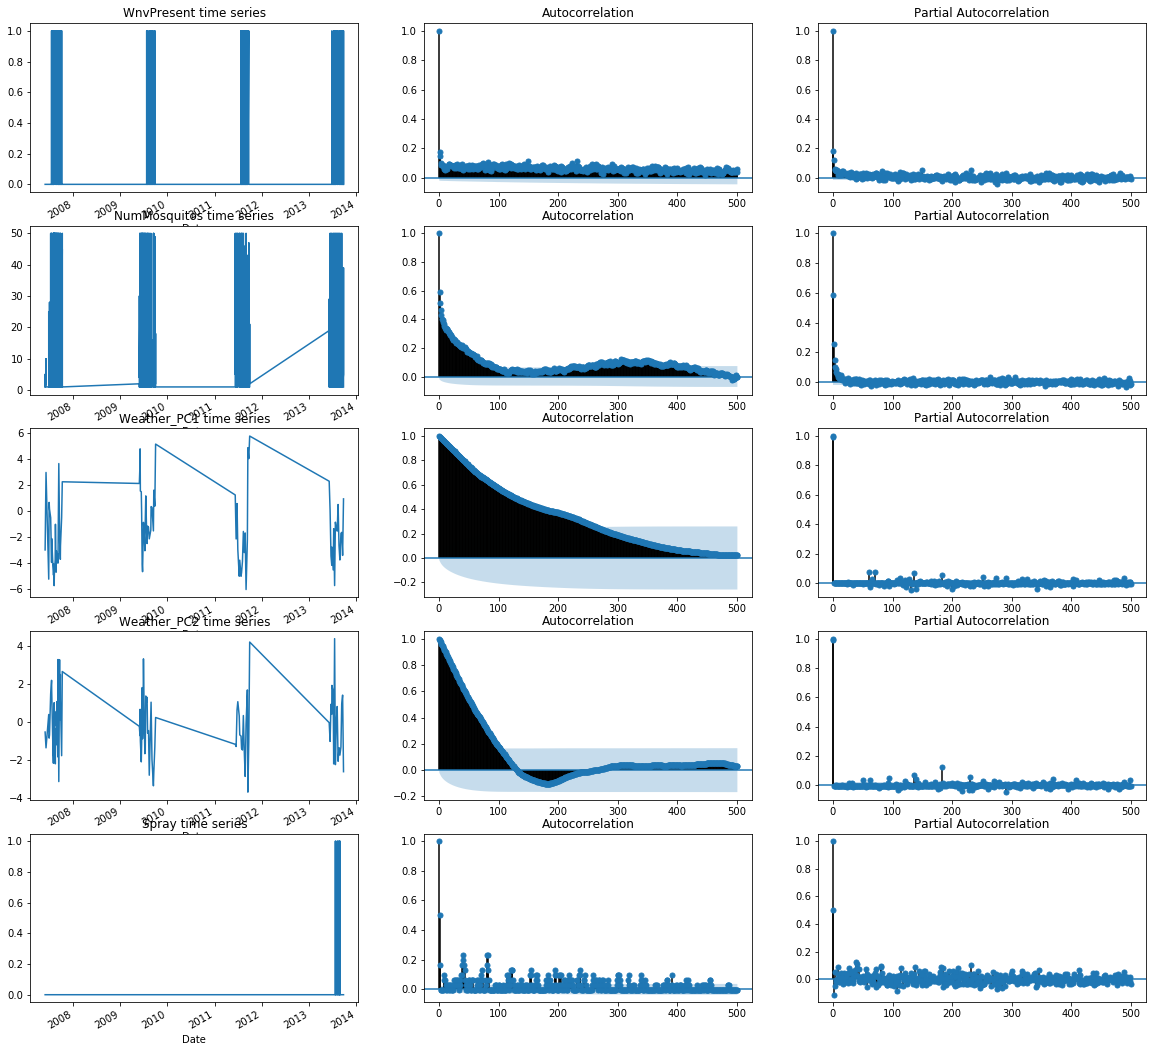

In [122]:
# Plotting a Partial Autocorrelation model to illustrate seasonal effects as Wnv is most prevalent in summer:

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))

train_df['WnvPresent'].plot(ax=ax[0,0], title='WnvPresent time series')
plot_acf(train_df['WnvPresent'], lags=500, ax=ax[0,1])
plot_pacf(train_df['WnvPresent'], lags=500, ax=ax[0,2])

train_df['NumMosquitos'].plot(ax=ax[1,0], title='NumMosquitos time series')
plot_acf(train_df['NumMosquitos'], lags=500, ax=ax[1,1])
plot_pacf(train_df['NumMosquitos'], lags=500, ax=ax[1,2])

train_df['weather_PC1'].plot(ax=ax[2,0], title='Weather_PC1 time series')
plot_acf(train_df['weather_PC1'], lags=500, ax=ax[2,1])
plot_pacf(train_df['weather_PC1'], lags=500, ax=ax[2,2])

train_df['weather_PC2'].plot(ax=ax[3,0], title='Weather_PC2 time series')
plot_acf(train_df['weather_PC2'], lags=500, ax=ax[3,1])
plot_pacf(train_df['weather_PC2'], lags=500, ax=ax[3,2])

train_df['isSpray'].plot(ax=ax[4,0], title='Spray time series')
plot_acf(train_df['isSpray'], lags=500, ax=ax[4,1])
plot_pacf(train_df['isSpray'], lags=500, ax=ax[4,2])

plt.show()

### Scatter plots

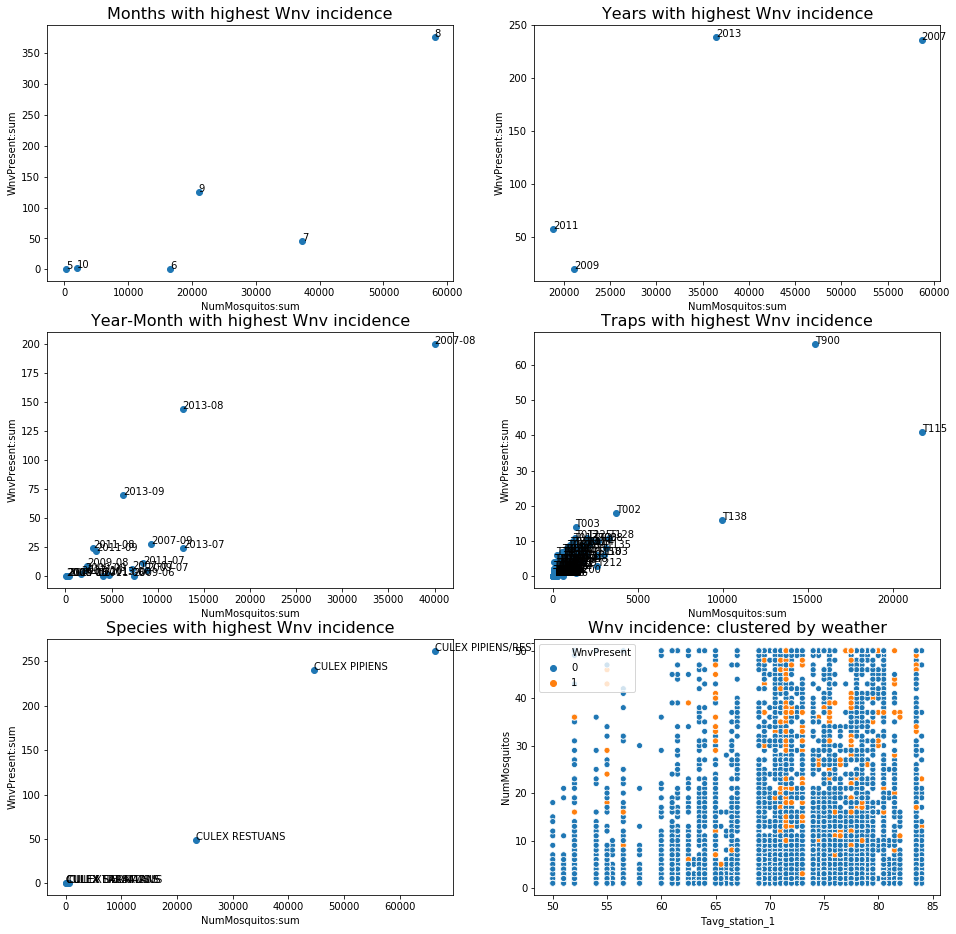

In [15]:
# When (ie, which summer month / which year) had the highest incidence of Wnv and NumMosquitos?
# And where (ie, which trap) had the highest incidence of Wnv and NumMosquitos?

train_month_grp = train.groupby(train.index.month).agg({'WnvPresent':'sum',
                                                        'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                            ascending=False)
train_year_grp = train.groupby(train.index.year).agg({'WnvPresent':'sum',
                                                      'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                          ascending=False)
train_monthyear_grp = train.groupby(train.index.to_period('M')).agg({'WnvPresent':'sum',
                                                                     'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                                         ascending=False)
train_trap_grp = train.groupby('Trap').agg({'WnvPresent':'sum',
                                            'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                ascending=False)
train_species_grp = train.groupby('Species').agg({'WnvPresent':'sum',
                                                  'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                      ascending=False)
# Scatter-plot both sets of data:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,16))
ax[0,0].scatter(train_month_grp['NumMosquitos'], train_month_grp['WnvPresent']);
for i, xi in enumerate(train_month_grp.index):
    ax[0,0].annotate(xi, (train_month_grp.iloc[i,1], train_month_grp.iloc[i,0]))
ax[0,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,0].set_title('Months with highest Wnv incidence', fontsize=16)

ax[0,1].scatter(train_year_grp['NumMosquitos'], train_year_grp['WnvPresent']);
for i, xi in enumerate(train_year_grp.index):
    ax[0,1].annotate(xi, (train_year_grp.iloc[i,1], train_year_grp.iloc[i,0]))
ax[0,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,1].set_title('Years with highest Wnv incidence', fontsize=16)

ax[1,0].scatter(train_monthyear_grp['NumMosquitos'], train_monthyear_grp['WnvPresent']);
for i, xi in enumerate(train_monthyear_grp.index):
    ax[1,0].annotate(xi, (train_monthyear_grp.iloc[i,1], train_monthyear_grp.iloc[i,0]))
ax[1,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,0].set_title('Year-Month with highest Wnv incidence', fontsize=16)

ax[1,1].scatter(train_trap_grp['NumMosquitos'], train_trap_grp['WnvPresent']);
for i, xi in enumerate(train_trap_grp.index):
    ax[1,1].annotate(xi, (train_trap_grp.iloc[i,1], train_trap_grp.iloc[i,0]))
ax[1,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,1].set_title('Traps with highest Wnv incidence', fontsize=16)

ax[2,0].scatter(train_species_grp['NumMosquitos'], train_species_grp['WnvPresent']);
for i, xi in enumerate(train_species_grp.index):
    ax[2,0].annotate(xi, (train_species_grp.iloc[i,1], train_species_grp.iloc[i,0]))
ax[2,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[2,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[2,0].set_title('Species with highest Wnv incidence', fontsize=16)

sns.scatterplot(train_df['Tavg_station_1'], train_df['NumMosquitos'], hue=train_df['WnvPresent'], ax=ax[2,1]);
ax[2,1].set_xlabel('Tavg_station_1', fontsize=10)
ax[2,1].set_ylabel('NumMosquitos', fontsize=10)
ax[2,1].set_title('Wnv incidence: clustered by weather', fontsize=16)

plt.show();

# Clear to see that both Wnv and NumMosquitos was highest in certain Traps, years, and months.

## Modelling

#### Setting up (X, y)

In [137]:
y, X = train_df['WnvPresent'], train_df[['Trap','weather_PC1','weather_PC2','weather_PC3','weather_PC4',
                                         'weather_PC5','weather_PC6','weather_PC7','weather_PC8',
                                         'weather_PC9','weather_PC10','isSpray']]
X_dum = pd.get_dummies(X, drop_first=True, columns=['Trap'])

# initialise classes generic to all models below:
poly = PolynomialFeatures(interaction_only=True)
std = StandardScaler()
sm = SMOTENC(categorical_features=list(range(10,139)))
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Sci-kit Learn GridSearchCV tuning classifiers

#### Decision Tree Classifier

In [138]:
dt = DecisionTreeClassifier(max_depth=None, random_state=1)
params = {'dt__max_depth':range(2,10)}

pipeline = Pipeline([('sm', sm), ('dt', dt)])

gs_dt = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_dt.fit(X_dum, y)
print(gs_dt.best_params_)
print(gs_dt.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.5min finished


{'dt__max_depth': 7}
0.7950679737771652


#### Random Forest Classifier

In [126]:
rf = RandomForestClassifier(n_estimators=100)
params = {'rf__max_depth': list(range(2,20,5)),
          'rf__min_samples_split': np.linspace(0.3,0.4,3)}

pipeline = Pipeline([('std', std), ('sm', sm), ('rf', rf)])

gs_rf = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_rf.fit(X_dum, y)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 747, in _queue_management_worker
    recursive_terminate(p)
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/joblib/extern

Traceback (most recent call last):
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/joblib/parallel.py", line 909, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 562, in wrap_future_result
    return future.result(timeout=timeout)
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/concurrent/futures/_base.py", line 430, in result
    self._condition.wait(timeout)
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/threading.py", line 296, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-126-

TypeError: can only concatenate str (not "list") to str

#### Gradient Boosting Classifier

In [73]:
gb = GradientBoostingClassifier(n_estimators=100, n_iter_no_change=20)
params = {'gb__learning_rate': np.linspace(.1,1.,4)}

pipeline = Pipeline([('std', std), ('sm', sm), ('gb', gb)])

gs_gb = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_gb.fit(X_dum, y)
print(gs_gb.best_params_)
print(gs_gb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.5min finished


{'gb__learning_rate': 1.0}
0.8763285024154589


#### Bagging Classifier

In [176]:
bc = BaggingClassifier(n_estimators=100)
params = {'bc__max_features': np.linspace(0.1,0.2,2)}

pipeline = Pipeline([('std', std), ('sm', sm), ('bc', bc)])

gs_bc = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_bc.fit(X_dum, y)
print(gs_bc.best_params_)
print(gs_bc.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.9min finished


{'bc__max_features': 0.1}
0.8197708484247912


#### Support Vector Machines

In [34]:
svm = SVC(kernel='rbf')
params = {'svm__C':np.logspace(-4,4,5),
          'svm__gamma':np.logspace(-4,4,5)}
    
pipeline = Pipeline([('std', std), ('sm', sm), ('svm', svm)])

gs_svm = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_svm.fit(X_dum, y)
print(gs_svm.best_params_)
print(gs_svm.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 38.9min
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed: 89.8min finished


{'svm__C': 100.0, 'svm__gamma': 0.01}
0.7503429108301031


### TensorFlow Keras Neural Network

In [183]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

def create_model(epochs, optimizer, batch_size, kernel_initializer_fn):
    tf_keras = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_dum.shape[1], )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])
    
    tf_keras.compile(loss='binary_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    return tf_keras

In [184]:
kerasclf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=1)
params = {'kerasclf__epochs': [100],
          'kerasclf__optimizer': ['sgd','adam'],
          'kerasclf__batch_size': [5, 10, 20],
          'kerasclf__kernel_initializer_fn': ['glorot_uniform', 'normal', 'uniform']}

pipeline = Pipeline([('std', std), ('sm', sm), ('kerasclf', kerasclf)])

gs_keras = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_keras.fit(X_dum, y)
print(gs_keras.best_params_)
print(gs_keras.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 236.9min
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed: 334.3min finished


Train on 19910 samples
Epoch 1/100
19910/19910 [==============================] - 8s 388us/sample - loss: 0.4473 - accuracy: 0.8233
Epoch 2/100
19910/19910 [==============================] - 8s 382us/sample - loss: 0.3588 - accuracy: 0.8657
Epoch 3/100
19910/19910 [==============================] - 7s 333us/sample - loss: 0.3268 - accuracy: 0.8769
Epoch 4/100
19910/19910 [==============================] - 7s 329us/sample - loss: 0.3111 - accuracy: 0.8844
Epoch 5/100
19910/19910 [==============================] - 7s 337us/sample - loss: 0.2995 - accuracy: 0.8908
Epoch 6/100
19910/19910 [==============================] - 7s 344us/sample - loss: 0.2947 - accuracy: 0.8925
Epoch 7/100
19910/19910 [==============================] - 7s 335us/sample - loss: 0.2935 - accuracy: 0.8957
Epoch 8/100
19910/19910 [==============================] - 8s 377us/sample - loss: 0.2905 - accuracy: 0.8958
Epoch 9/100
19910/19910 [==============================] - 8s 388us/sample - loss: 0.2829 - accuracy: 0.8

19910/19910 [==============================] - 6s 326us/sample - loss: 0.2459 - accuracy: 0.9154
Epoch 75/100
19910/19910 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.91 - 7s 332us/sample - loss: 0.2435 - accuracy: 0.9174
Epoch 76/100
19910/19910 [==============================] - 7s 327us/sample - loss: 0.2425 - accuracy: 0.9173
Epoch 77/100
19910/19910 [==============================] - 7s 328us/sample - loss: 0.2409 - accuracy: 0.9167
Epoch 78/100
19910/19910 [==============================] - 7s 339us/sample - loss: 0.2418 - accuracy: 0.9193
Epoch 79/100
19910/19910 [==============================] - 6s 326us/sample - loss: 0.2455 - accuracy: 0.9150
Epoch 80/100
19910/19910 [==============================] - 7s 337us/sample - loss: 0.2493 - accuracy: 0.9136
Epoch 81/100
19910/19910 [==============================] - 7s 341us/sample - loss: 0.2409 - accuracy: 0.9155
Epoch 82/100
19910/19910 [==============================] - 7s 327us/sample - loss: 0.2454 

In [188]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
EPOCHS = 1000

model = create_model(epochs=100, optimizer='sgd', batch_size=5, kernel_initializer_fn='normal')
history = model.fit(X_dum, y.values,
                       epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop])

In [190]:
model.evaluate(X_dum, y.values, verbose=2)

10506/10506 - 0s - loss: 0.2026 - accuracy: 0.9476


[0.2026377199839423, 0.94755375]

In [204]:
sorted(model.predict(X_dum).argmax(axis=1), reverse=True) # why just prob of 0?

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [200]:
roc_auc_score(y, model.predict(X_dum).argmax(axis=1))

0.5

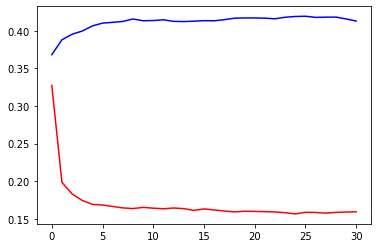

In [207]:
plt.plot(history.history['loss'],c='r')
plt.plot(history.history['val_loss'],c='b')
plt.show()

In [191]:
# Did I do this keras operation correctly?

# Then make a first submission to Kaggle of test data.

# Take the best model and plot the predicted in Tableau, perhaps a movie, to sense-check how it works.
# Look at how best to visualise the performance of each classifier

# Migrate operation onto AWS to tune 